In [1]:
import pandas as pd
import numpy as np
import glob
import datetime as dt
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import pytz

In [2]:
def add_lt(df,tz):
    df["lt"] = df.index.tz_localize(pytz.utc).tz_convert(pytz.timezone(tz))
    return df

def load_scws(rid,tz):
    print("loading "+rid+"...")
    df1 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/"+rid+"_scw_envs_df.csv")
    df2 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/"+rid+"_non_scw_envs_df.csv")
    
    df1["cluster_new"] = df1.cluster.map({0:2,1:0,2:1})
    df1 = df1.set_index(pd.DatetimeIndex(df1.dt_utc))
    df1 = add_lt(df1,tz)    
    df1["month"] = df1.index.month
    df1["hour"] = df1["lt"].dt.hour
    df1["year"] = df1.index.year
    df1["aspect_ratio"] = df1.major_axis_length / df1.minor_axis_length    
    
    df2["cluster_new"] = df2.cluster.map({0:2,1:0,2:1})
    df2 = df2.set_index(pd.DatetimeIndex(df2.dt_utc))
    df2 = add_lt(df2,tz)            
    df2["month"] = df2.index.month
    df2["hour"] = df2["lt"].dt.hour
    df2["year"] = df2.index.year    
    df2["aspect_ratio"] = df2.major_axis_length / df2.minor_axis_length     
    
    df1["rid"] = rid
    df2["rid"] = rid

    
    return df1, df2

In [3]:
melb_scw, melb_null = load_scws("2",'Australia/Melbourne')
bris_scw, bris_null = load_scws("66",'Australia/Brisbane')
namoi_scw, namoi_null = load_scws("69",'Australia/Sydney')
perth_scw, perth_null = load_scws("70",'Australia/Perth')
syd_scw, syd_null = load_scws("71",'Australia/Sydney')

loading 2...
loading 66...
loading 69...
loading 70...
loading 71...


In [4]:
def print_events(df,name):
    print(name,": ",df.shape)
    
[print_events(d,n) for d,n in zip([melb_scw,bris_scw,namoi_scw,perth_scw,syd_scw],["MELB","BRIS","NAMOI","PERTH","SYD"])]

MELB :  (153, 177)
BRIS :  (27, 177)
NAMOI :  (55, 177)
PERTH :  (49, 177)
SYD :  (78, 177)


[None, None, None, None, None]

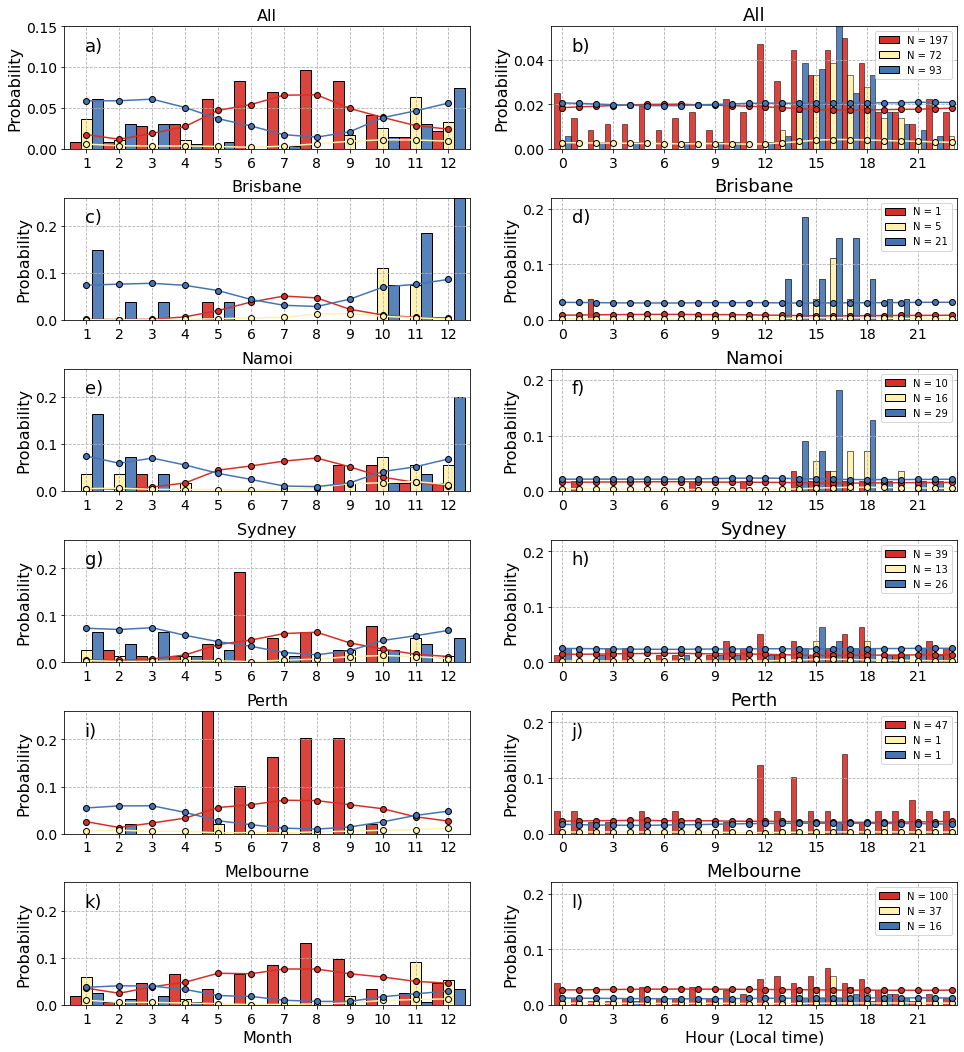

In [5]:
def create_legend(ax,p,labels):
    
    #create legend
    handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in p]
    plt.legend(handles, labels, loc="upper right")

def plot_hists(data, title, ax1, ax2, ymax1, ymax2, kde=False, plot_total_counts=True, null_data=None):
    
    p = [plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]
    
    sns.histplot(x="month",data=data,discrete=True,hue="cluster_new",multiple="dodge",palette=p, ax=ax1, legend=False, stat="probability", kde=kde, alpha=0.9,
                line_kws={"lw":3},common_norm=True)
    ax1.set_title(title,size=16)
    ax1.grid(ls="--")
    ax1.set_ylim([0,ymax1])
    ax1.set_xticks(np.arange(1,13))
    ax1.set_xlim([0.33,12.66])
    ax1.set_xlabel("")
    ax1.yaxis.label.set_size(16)
    ax1.tick_params("both",labelsize=14)
    create_legend(ax1, p, ["N = "+str((data.cluster_new==i).sum()) for i in np.arange(3)])
    
    if plot_total_counts:
        counts = null_data[["month","cluster_new"]].groupby(["cluster_new","month"]).agg("size")
        counts = counts / null_data.shape[0]
        ax1.plot(counts.loc[0],color=p[0],marker="o",mec="k")
        ax1.plot(counts.loc[1],color=p[1],marker="o",mec="k")
        ax1.plot(counts.loc[2],color=p[2],marker="o",mec="k")
    
    sns.histplot(x="hour",data=data,discrete=True,hue="cluster_new",multiple="dodge",palette=p, ax=ax2, legend=False, stat="probability", kde=kde, alpha=0.9,
                line_kws={"lw":3},common_norm=True)
    ax2.set_title(title,size=18)
    ax2.grid(ls="--")
    ax2.set_ylim([0,ymax2])    
    ax2.set_xlabel("")
    ax2.set_xticks(np.arange(0,24,3))
    ax2.set_xlim([-0.66,23.33])
    ax2.yaxis.label.set_size(16)
    ax2.tick_params("both",labelsize=14)
    create_legend(ax1, p, ["N = "+str((data.cluster_new==i).sum()) for i in np.arange(3)])
    
    if plot_total_counts:
        counts = null_data[["hour","cluster_new"]].groupby(["cluster_new","hour"]).agg("size")
        counts = counts / null_data.shape[0]
        ax2.plot(counts.loc[0],color=p[0],marker="o",mec="k")
        ax2.plot(counts.loc[1],color=p[1],marker="o",mec="k")
        ax2.plot(counts.loc[2],color=p[2],marker="o",mec="k")    

plt.figure(figsize=[16,18])

rows=6; cols=2




ax1 = plt.subplot(rows,cols,1); ax2 = plt.subplot(rows,cols,2)
plot_hists(pd.concat([melb_scw, syd_scw, bris_scw, perth_scw, namoi_scw], axis=0), "All", ax1, ax2, 0.15, 0.055, kde=False,
          null_data=pd.concat([melb_null[["cluster_new","hour","month"]], syd_null[["cluster_new","hour","month"]], bris_null[["cluster_new","hour","month"]], 
                               perth_null[["cluster_new","hour","month"]], namoi_null[["cluster_new","hour","month"]],
                                melb_scw[["cluster_new","hour","month"]], syd_scw[["cluster_new","hour","month"]], bris_scw[["cluster_new","hour","month"]], 
                               perth_scw[["cluster_new","hour","month"]], namoi_scw[["cluster_new","hour","month"]]],                              
                              axis=0))
ax1.text(0.05,0.8,"a)",size=18,transform=ax1.transAxes)
ax2.text(0.05,0.8,"b)",size=18,transform=ax2.transAxes)

ax1 = plt.subplot(rows,cols,3); ax2 = plt.subplot(rows,cols,4)
plot_hists(bris_scw, "Brisbane", ax1, ax2, 0.26, 0.22, null_data=pd.concat([bris_null[["cluster_new","hour","month"]],bris_scw[["cluster_new","hour","month"]]]))
ax1.text(0.05,0.8,"c)",size=18,transform=ax1.transAxes)
ax2.text(0.05,0.8,"d)",size=18,transform=ax2.transAxes)

ax1 = plt.subplot(rows,cols,5); ax2 = plt.subplot(rows,cols,6)
plot_hists(namoi_scw, "Namoi", ax1, ax2, 0.26, .22, null_data=pd.concat([namoi_null[["cluster_new","hour","month"]],namoi_scw[["cluster_new","hour","month"]]]))
ax1.text(0.05,0.8,"e)",size=18,transform=ax1.transAxes)
ax2.text(0.05,0.8,"f)",size=18,transform=ax2.transAxes)

ax1 = plt.subplot(rows,cols,7); ax2 = plt.subplot(rows,cols,8)
plot_hists(syd_scw, "Sydney", ax1, ax2, 0.26, .22, null_data=pd.concat([syd_null[["cluster_new","hour","month"]],syd_scw[["cluster_new","hour","month"]]]))
ax1.text(0.05,0.8,"g)",size=18,transform=ax1.transAxes)
ax2.text(0.05,0.8,"h)",size=18,transform=ax2.transAxes)

ax1 = plt.subplot(rows,cols,9); ax2 = plt.subplot(rows,cols,10)
plot_hists(perth_scw, "Perth", ax1, ax2, 0.26, .22, null_data=pd.concat([perth_null[["cluster_new","hour","month"]],perth_scw[["cluster_new","hour","month"]]]))
ax1.text(0.05,0.8,"i)",size=18,transform=ax1.transAxes)
ax2.text(0.05,0.8,"j)",size=18,transform=ax2.transAxes)

ax1 = plt.subplot(rows,cols,11); ax2 = plt.subplot(rows,cols,12)
plot_hists(melb_scw, "Melbourne", ax1, ax2, 0.26, .22, null_data=pd.concat([melb_null[["cluster_new","hour","month"]],melb_scw[["cluster_new","hour","month"]]]))
ax1.text(0.05,0.8,"k)",size=18,transform=ax1.transAxes)
ax2.text(0.05,0.8,"l)",size=18,transform=ax2.transAxes)

ax1.set_xlabel("Month", size=16); ax2.set_xlabel("Hour (Local time)", size=16)
plt.subplots_adjust(hspace=0.4)

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/scws_cluster_temporal_hist.jpeg",dpi=1000,bbox_inches="tight")

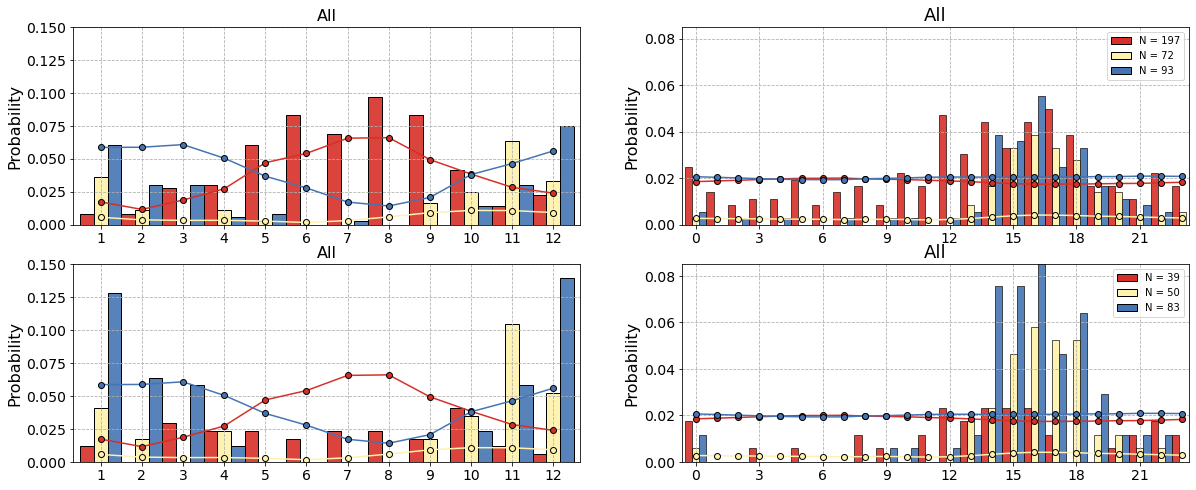

In [6]:
plt.figure(figsize=[20,8])

plot_hists(
    pd.concat([melb_scw, syd_scw, bris_scw, perth_scw, namoi_scw], axis=0), 
           "All", plt.subplot(2,2,1), plt.subplot(2,2,2), 0.15, 0.085, kde=False,
          null_data=
          pd.concat([melb_null[["cluster_new","hour","month"]], syd_null[["cluster_new","hour","month"]], bris_null[["cluster_new","hour","month"]], 
                              perth_null[["cluster_new","hour","month"]], namoi_null[["cluster_new","hour","month"]],
                               melb_scw[["cluster_new","hour","month"]], syd_scw[["cluster_new","hour","month"]], bris_scw[["cluster_new","hour","month"]], 
                              perth_scw[["cluster_new","hour","month"]], namoi_scw[["cluster_new","hour","month"]]],                              
                             axis=0)
          )

plot_hists(
    pd.concat([melb_scw.query("(Lightning_observed>=1)"), syd_scw.query("(Lightning_observed>=1)"), bris_scw.query("(Lightning_observed>=1)"), 
                     perth_scw.query("(Lightning_observed>=1)"), namoi_scw.query("(Lightning_observed>=1)")]
                    , axis=0), 
    "All", plt.subplot(2,2,3), plt.subplot(2,2,4), 0.15, 0.085, kde=False,
          null_data=
    pd.concat([melb_null[["cluster_new","hour","month"]], syd_null[["cluster_new","hour","month"]], bris_null[["cluster_new","hour","month"]], 
                              perth_null[["cluster_new","hour","month"]], namoi_null[["cluster_new","hour","month"]],
                               melb_scw[["cluster_new","hour","month"]], syd_scw[["cluster_new","hour","month"]], bris_scw[["cluster_new","hour","month"]], 
                              perth_scw[["cluster_new","hour","month"]], namoi_scw[["cluster_new","hour","month"]]],                              
                             axis=0)
)

In [18]:
def print_events(df,name):
    print(name,": ",df.shape)
    
[print_events(d,n) for d,n in zip([melb_scw,bris_scw,namoi_scw,perth_scw,syd_scw,data],["MELB","BRIS","NAMOI","PERTH","SYD","ALL"])]

MELB :  (153, 177)
BRIS :  (27, 177)
NAMOI :  (55, 177)
PERTH :  (49, 177)
SYD :  (78, 177)
ALL :  (349, 178)


[None, None, None, None, None, None]

In [19]:
def plot_box(ax,v,df,yscale,y1,y2):
    p = [(0.5,0.5,0.5)]+[plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]
    sns.boxplot(data=df,x="cluster_new",y=v,whis=1.5,palette=p)    
    plt.ylabel(v,size=14)
    ax.set_yscale(yscale)
    ax.tick_params(labelsize=12)
    plt.ylim([y1,y2])
    ax.grid(axis="y")


In [21]:
data=pd.concat([melb_scw, syd_scw, bris_scw, perth_scw, namoi_scw], axis=0).dropna(subset=["azi_shear60"])
data["scw"] = 1
data_null=pd.concat([melb_null.query("in10km==1"), 
                     syd_null.query("in10km==1"), 
                     bris_null.query("in10km==1"),
                     perth_null.query("in10km==1"), 
                     namoi_null.query("in10km==1")], axis=0).dropna(subset=["azi_shear60"])
data_null["scw"] = 0
data_null=data_null.drop_duplicates(["year","month","rid","uid10"])
#data_null["cluster_new"] = -1
data = pd.concat([data,data_null],axis=0)
data["wgr_sherb"] = data["gust"] / data["speed"]

No SCW (N=0)
 Strong background wind (N=23080)
 Steep lapse rate (N=6741)
 High moisture (N=32908)

No SCW (N=0)
 Strong background wind (N=13553)
 Steep lapse rate (N=4408)
 High moisture (N=24822)



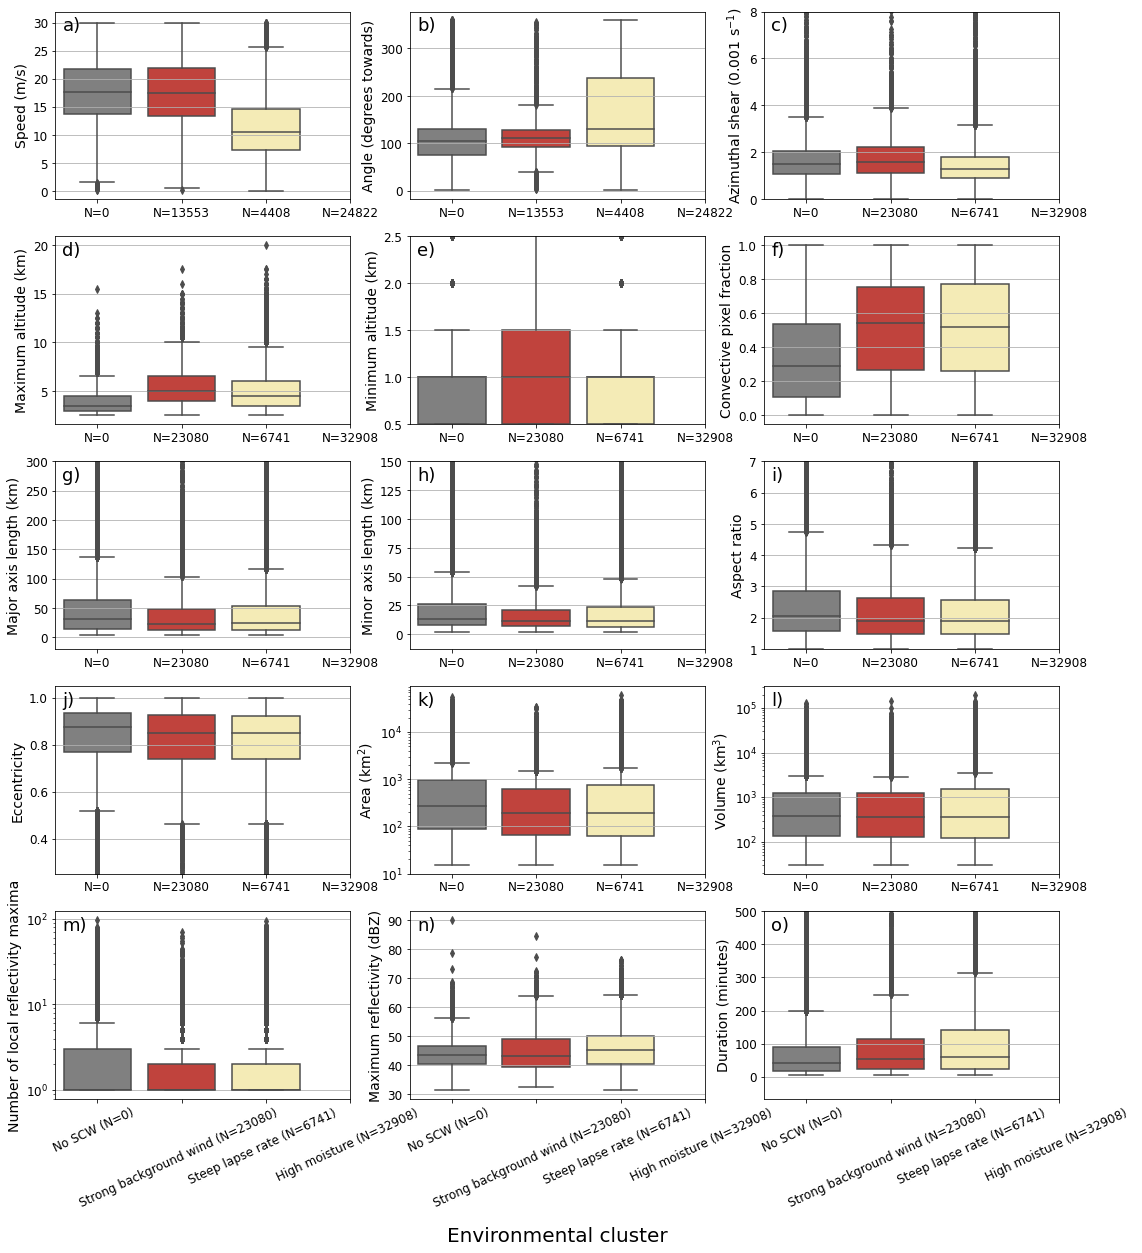

In [23]:
var = ["speed","angle","azi_shear","max_alt","min_alt","conv_pct","major_axis_length","minor_axis_length",
       "aspect_ratio","eccentricity","area_km","vol","local_max","field_max","duration_mins"]
renames={"speed":"Speed (m/s)","angle":"Angle (degrees towards)","max_alt":"Maximum altitude (km)",
         "min_alt":"Minimum altitude (km)","conv_pct":"Convective pixel fraction","major_axis_length":"Major axis length (km)",
         "minor_axis_length":"Minor axis length (km)","aspect_ratio":"Aspect ratio","eccentricity":"Eccentricity","area_km":"Area (km$^{2}$)",
         "vol":"Volume (km$^{3}$)","local_max":"Number of local reflectivity maxima","field_max":"Maximum reflectivity (dBZ)",
         "azi_shear":"Azimuthal shear (0.001 s$^{-1})$","duration_mins":"Duration (minutes)"}
log_vars = ["area_km","local_max","vol"]
symlog_vars = []
yscales = dict.fromkeys(var,"linear"); 
for v in log_vars:
    yscales[v]="log" 
for v in symlog_vars:
    yscales[v]="symlog"     
y1 = dict.fromkeys(var,None)
y2 = dict.fromkeys(var,None); 
y1["azi_shear"] = 0; y1["min_alt"] = 0.5; y1["aspect_ratio"] = 1; y1["eccentricity"] = 0.25
y2["speed"]=32; y2["min_alt"] = 2.5; y2["azi_shear"] = 8; y2["major_axis_length"]=300; y2["minor_axis_length"]=150; y2["aspect_ratio"]=7; 
y2["duration_mins"]=500
letters=["a","b","c","d","e","f","g","h","i","j","k","l","m","n","o"]

plt.figure(figsize=[18,20])
for i in np.arange(len(var)):
    ax=plt.subplot(5,3,i+1)
    if var[i] in ["speed","angle","wgr_sherb"]:
        plot_box(ax,var[i],data.query("(speed_rnge<4) & (speed<30)"),yscales[var[i]],y1[var[i]],y2[var[i]])
    else:
        plot_box(ax,var[i],data,yscales[var[i]],y1[var[i]],y2[var[i]])
    plt.ylabel(renames[var[i]])
    plt.xlabel("")
    if var[i] in ["local_max","field_max","duration_mins"]:
        ax.set_xticks([0,1,2,3])
        #ax.set_xticklabels(["No SCW","Strong background wind","Steep lapse rate","High moisture"])
        ax.set_xticklabels(["No SCW (N="+str(data.query("cluster_new==-1").shape[0])+")\n",
                            "Strong background wind (N="+str(data.query("cluster_new==0").shape[0])+")\n",
                            "Steep lapse rate (N="+str(data.query("cluster_new==1").shape[0])+")\n",
                            "High moisture (N="+str(data.query("cluster_new==2").shape[0])+")\n"])
        ax.tick_params("x",rotation=25)
    elif var[i] in ["speed","angle"]:
        ax.set_xticks([0,1,2,3])
        ax.set_xticklabels(["N="+str(data.query("(speed_rnge<4) & (speed<30)").query("cluster_new==-1").shape[0]),
                            "N="+str(data.query("(speed_rnge<4) & (speed<30)").query("cluster_new==0").shape[0]),
                            "N="+str(data.query("(speed_rnge<4) & (speed<30)").query("cluster_new==1").shape[0]),
                            "N="+str(data.query("(speed_rnge<4) & (speed<30)").query("cluster_new==2").shape[0])])      
    else:
        ax.set_xticks([0,1,2,3])
        ax.set_xticklabels(["N="+str(data.query("cluster_new==-1").shape[0]),
                            "N="+str(data.query("cluster_new==0").shape[0]),
                            "N="+str(data.query("cluster_new==1").shape[0]),
                            "N="+str(data.query("cluster_new==2").shape[0])])      
        
    if var[i]=="field_max":
        plt.xlabel("Environmental cluster",size=20)
    ax.text(0.025,0.9,letters[i]+")",size=18,transform=ax.transAxes)

print("No SCW (N="+str(data.query("cluster_new==-1").shape[0])+")\n",
                            "Strong background wind (N="+str(data.query("cluster_new==0").shape[0])+")\n",
                            "Steep lapse rate (N="+str(data.query("cluster_new==1").shape[0])+")\n",
                            "High moisture (N="+str(data.query("cluster_new==2").shape[0])+")\n")
print("No SCW (N="+str(data.query("(speed_rnge<4) & (speed<30)").query("cluster_new==-1").shape[0])+")\n",
                            "Strong background wind (N="+str(data.query("(speed_rnge<4) & (speed<30)").query("cluster_new==0").shape[0])+")\n",
                            "Steep lapse rate (N="+str(data.query("(speed_rnge<4) & (speed<30)").query("cluster_new==1").shape[0])+")\n",
                            "High moisture (N="+str(data.query("(speed_rnge<4) & (speed<30)").query("cluster_new==2").shape[0])+")\n")
        
plt.subplots_adjust(hspace=0.2)
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/scws_storm_hist_cluster.jpeg",dpi=500,bbox_inches="tight")

No SCW (N=0)
 Strong background wind (N=23080)
 Steep lapse rate (N=6741)
 High moisture (N=32908)

No SCW (N=0)
 Strong background wind (N=13553)
 Steep lapse rate (N=4408)
 High moisture (N=24822)



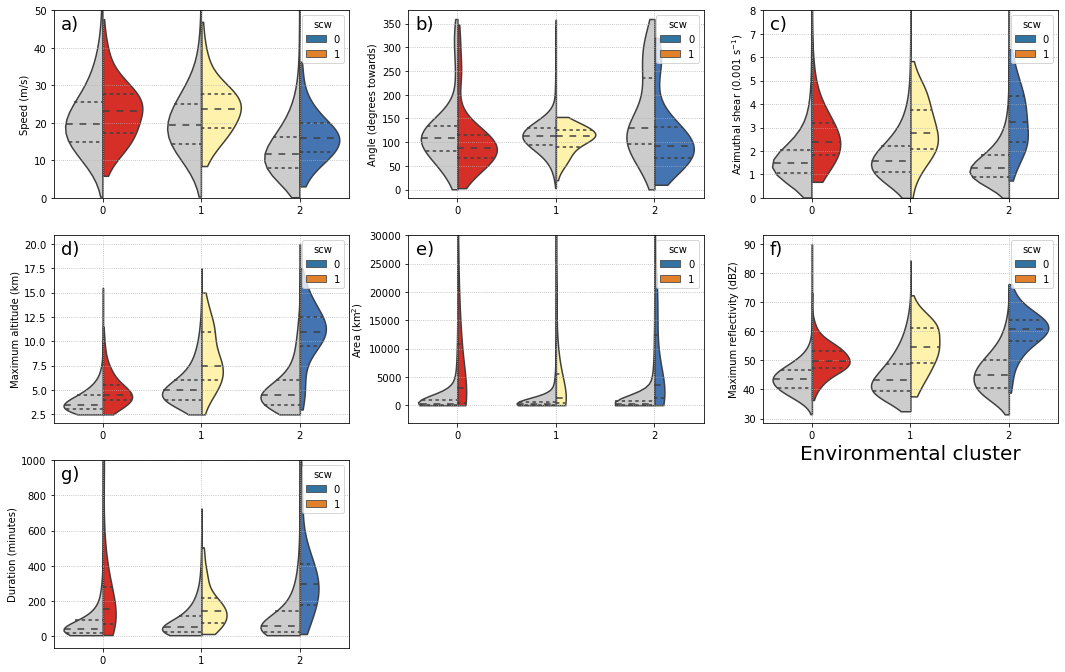

In [55]:
from matplotlib.colors import to_rgb
from matplotlib.collections import PolyCollection

def plot_split_violin(ax,v,data,yscale,y0,y1):

    p=[plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]
    sns.violinplot(data=data,y=v,x="cluster_new",cut=0,inner="quartile",hue="scw",split=True,bw=0.5,ax=ax)
    ax=plt.gca()
    colors = p
    for ind, violin in enumerate(ax.findobj(PolyCollection)):
        rgb = to_rgb(colors[ind // 2])
        if ind % 2 != 1:
            rgb = [0.8,0.8,0.8] 
        violin.set_facecolor(rgb)

    plt.gca().grid(ls=":")
    plt.gca().set_yscale(yscale)    
    plt.gca().set_ylim([y0,y1])

    
    
    
var = ["speed","angle","azi_shear","max_alt","area_km","field_max","duration_mins"]
renames={"speed":"Speed (m/s)","angle":"Angle (degrees towards)","max_alt":"Maximum altitude (km)",
         "min_alt":"Minimum altitude (km)","conv_pct":"Convective pixel fraction","major_axis_length":"Major axis length (km)",
         "minor_axis_length":"Minor axis length (km)","aspect_ratio":"Aspect ratio","eccentricity":"Eccentricity","area_km":"Area (km$^{2}$)",
         "vol":"Volume (km$^{3}$)","local_max":"Number of local reflectivity maxima","field_max":"Maximum reflectivity (dBZ)",
         "azi_shear":"Azimuthal shear (0.001 s$^{-1})$","duration_mins":"Duration (minutes)"}
log_vars = ["local_max","vol"]
symlog_vars = []
yscales = dict.fromkeys(var,"linear"); 
for v in log_vars:
    yscales[v]="log" 
for v in symlog_vars:
    yscales[v]="symlog"     
y1 = dict.fromkeys(var,None)
y2 = dict.fromkeys(var,None); 
y1["azi_shear"] = 0; y1["min_alt"] = 0.5; y1["aspect_ratio"] = 1; y1["eccentricity"] = 0.25; y1["speed"]=0
y2["speed"]=50; y2["min_alt"] = 2.5; y2["azi_shear"] = 8; y2["major_axis_length"]=300; y2["minor_axis_length"]=150; y2["aspect_ratio"]=7; 
y2["duration_mins"]=1000; y2["area_km"]=30000
letters=["a","b","c","d","e","f","g","h","i","j","k","l","m","n","o"]

plt.figure(figsize=[18,20])
for i in np.arange(len(var)):
    ax=plt.subplot(5,3,i+1)

    plot_split_violin(ax,var[i],data,yscales[var[i]],y1[var[i]],y2[var[i]])
    
    plt.ylabel(renames[var[i]])
    plt.xlabel("")
#     if var[i] in ["local_max","field_max","duration_mins"]:
#         ax.set_xticks([0,1,2,3])
#         ax.set_xticklabels(["No SCW (N="+str(data.query("cluster_new==-1").shape[0])+")\n",
#                             "Strong background wind (N="+str(data.query("cluster_new==0").shape[0])+")\n",
#                             "Steep lapse rate (N="+str(data.query("cluster_new==1").shape[0])+")\n",
#                             "High moisture (N="+str(data.query("cluster_new==2").shape[0])+")\n"])
#         ax.tick_params("x",rotation=25)
#     else:
#         ax.set_xticks([0,1,2,3])
#         ax.set_xticklabels(["N="+str(data.query("cluster_new==-1").shape[0]),
#                             "N="+str(data.query("cluster_new==0").shape[0]),
#                             "N="+str(data.query("cluster_new==1").shape[0]),
#                             "N="+str(data.query("cluster_new==2").shape[0])])      
        
    if var[i]=="field_max":
        plt.xlabel("Environmental cluster",size=20)
    ax.text(0.025,0.9,letters[i]+")",size=18,transform=ax.transAxes)

print("No SCW (N="+str(data.query("cluster_new==-1").shape[0])+")\n",
                            "Strong background wind (N="+str(data.query("cluster_new==0").shape[0])+")\n",
                            "Steep lapse rate (N="+str(data.query("cluster_new==1").shape[0])+")\n",
                            "High moisture (N="+str(data.query("cluster_new==2").shape[0])+")\n")
print("No SCW (N="+str(data.query("(speed_rnge<4) & (speed<30)").query("cluster_new==-1").shape[0])+")\n",
                            "Strong background wind (N="+str(data.query("(speed_rnge<4) & (speed<30)").query("cluster_new==0").shape[0])+")\n",
                            "Steep lapse rate (N="+str(data.query("(speed_rnge<4) & (speed<30)").query("cluster_new==1").shape[0])+")\n",
                            "High moisture (N="+str(data.query("(speed_rnge<4) & (speed<30)").query("cluster_new==2").shape[0])+")\n")
        
plt.subplots_adjust(hspace=0.2)
#plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/scws_storm_hist_cluster.jpeg",dpi=500,bbox_inches="tight")

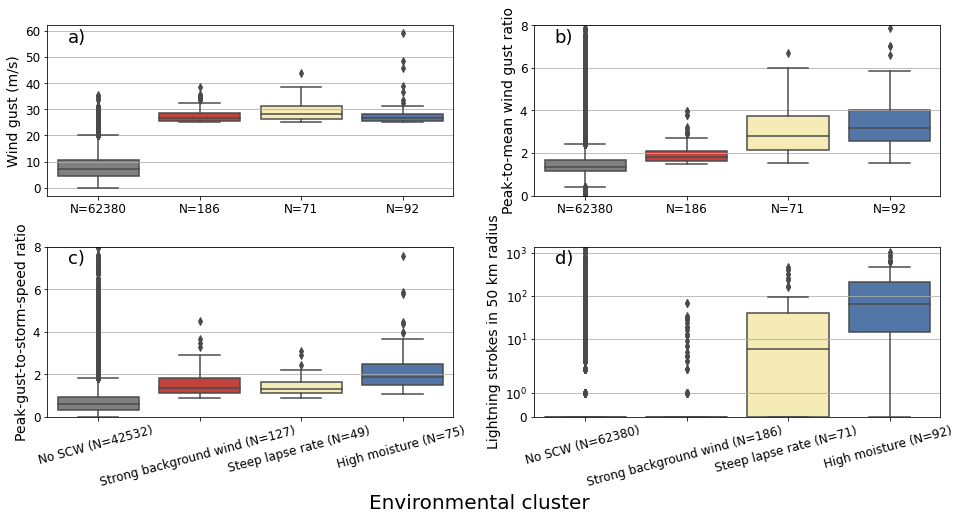

In [25]:
var = ["gust","wgr_4","wgr_sherb","Lightning_observed"]
renames={"gust":"Wind gust (m/s)","wgr_4":"Peak-to-mean wind gust ratio","wgr_sherb":"Peak-gust-to-storm-speed ratio",
         "Lightning_observed":"Lightning strokes in 50 km radius"}
log_vars = []
symlog_vars = ["Lightning_observed"]
yscales = dict.fromkeys(var,"linear"); 
for v in log_vars:
    yscales[v]="log" 
for v in symlog_vars:
    yscales[v]="symlog"     
y1 = dict.fromkeys(var,None)
y2 = dict.fromkeys(var,None); 
y2["gust"]=None; y2["wgr_4"]=8; y2["wgr_sherb"]=8
y1["wgr_4"]=0; y1["wgr_sherb"]=0; y1["Lightning_observed"]=0

letters=["a","b","c","d"]
fig=plt.figure(figsize=[16,8])
for i in np.arange(len(var)):
    ax=plt.subplot(2,2,i+1)
    if var[i] in ["speed","angle","wgr_sherb"]:
        plot_box(ax,var[i],data.query("(speed_rnge<4) & (speed<30)"),yscales[var[i]],y1[var[i]],y2[var[i]])
    else:
        plot_box(ax,var[i],data,yscales[var[i]],y1[var[i]],y2[var[i]])
    plt.ylabel(renames[var[i]])
    plt.xlabel("")
    if var[i] in ["wgr_sherb"]:
        ax.set_xticks([0,1,2,3])
        ax.set_xticklabels(["No SCW (N="+str(data.query("(speed_rnge<4) & (speed<30)").query("cluster_new==-1").shape[0])+")\n",
                            "Strong background wind (N="+str(data.query("(speed_rnge<4) & (speed<30)").query("cluster_new==0").shape[0])+")\n",
                            "Steep lapse rate (N="+str(data.query("(speed_rnge<4) & (speed<30)").query("cluster_new==1").shape[0])+")\n",
                            "High moisture (N="+str(data.query("(speed_rnge<4) & (speed<30)").query("cluster_new==2").shape[0])+")\n"])
        ax.tick_params("x",rotation=15)                  
    elif var[i] in ["Lightning_observed"]:
        ax.set_xticks([0,1,2,3])
        ax.set_xticklabels(["No SCW (N="+str(data.query("cluster_new==-1").shape[0])+")\n",
                            "Strong background wind (N="+str(data.query("cluster_new==0").shape[0])+")\n",
                            "Steep lapse rate (N="+str(data.query("cluster_new==1").shape[0])+")\n",
                            "High moisture (N="+str(data.query("cluster_new==2").shape[0])+")\n"])
        ax.tick_params("x",rotation=15)
    else:
        ax.set_xticks([0,1,2,3])
        ax.set_xticklabels(["N="+str(data.query("cluster_new==-1").shape[0]),
                            "N="+str(data.query("cluster_new==0").shape[0]),
                            "N="+str(data.query("cluster_new==1").shape[0]),
                            "N="+str(data.query("cluster_new==2").shape[0])])  
    ax.text(0.05,0.9,letters[i]+")",size=18,transform=ax.transAxes)
        
fig.text(0.5,0.05,"Environmental cluster",va="center",ha="center",size=20)
        
plt.subplots_adjust(hspace=0.3,bottom=0.2)
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/scws_obs_hist_cluster.jpeg",dpi=500,bbox_inches="tight")
